# Caligraphomate

Simulation graphique avec matplotlib (remplace les commandes du bras par des tracés sur une figure 2D)


## SImulation tracé contour

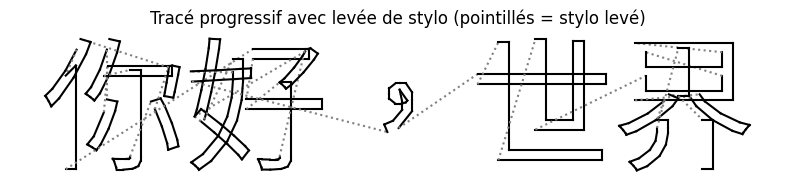

In [1]:
# Ce code extrait les contours vectoriels des caractères d’un texte via FreeType, 
# puis les trace progressivement, en distinguant les déplacements « stylo levé » et « stylo baissé » 

#Bibliothèque vectorielle pour les caractères :
#https://freetype-py.readthedocs.io/en/latest/screenshots.html

import freetype
import matplotlib.pyplot as plt
import time

text = "你好，世界"
#text="Hello world"

font_path = "NotoSansTC-Regular.ttf"

face = freetype.Face(font_path)
face.set_char_size(64 * 64)

pen_x = 0
all_paths = []

# construction des contours avec position absolue
for char in text:
    face.load_char(char, freetype.FT_LOAD_NO_BITMAP)
    slot = face.glyph
    outline = slot.outline

    points = outline.points
    contours = outline.contours
    start = 0

    offset_x = pen_x
    offset_y = slot.metrics.horiBearingY /64

    for contour_end in contours:
        contour = points[start:contour_end + 1]
        contour = [(x + offset_x, offset_y + y) for (x, y) in contour]
        all_paths.append(contour)
        start = contour_end + 1

    pen_x += slot.advance.x 

# tracé progressif sur une seule figure
plt.ion()
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title("Tracé progressif avec levée de stylo (pointillés = stylo levé)")

current_pos = None

for contour in all_paths:
    xs, ys = zip(*contour)

    # Déplacement à vide (stylo levé) si nécessaire
    if current_pos is not None:
        x0, y0 = current_pos
        x1, y1 = xs[0], ys[0]
        ax.plot([x0, x1], [y0, y1], linestyle='dotted', color='gray')
        fig.canvas.flush_events()
        time.sleep(0.01)

    # Tracé du contour (stylo abaissé)
    for i in range(len(xs) - 1):
        ax.plot([xs[i], xs[i + 1]], [ys[i], ys[i + 1]], color='black')
        fig.canvas.flush_events()
        time.sleep(0.01)

    current_pos = (xs[-1], ys[-1])

plt.ioff()
plt.show()


## Simulation tracé traits

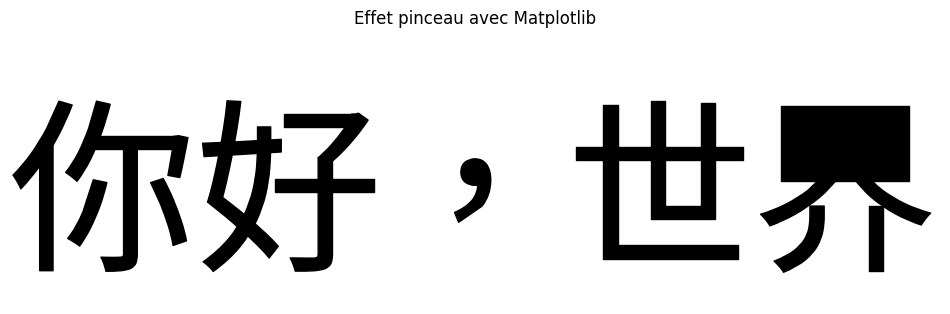

In [7]:
import freetype
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

text = "你好，世界"
#text="Hello world"
font_path = "NotoSansTC-Regular.ttf"

face = freetype.Face(font_path)
face.set_char_size(64 * 64)

pen_x = 0
paths = []

for char in text:
    face.load_char(char, freetype.FT_LOAD_NO_BITMAP)
    glyph = face.glyph
    outline = glyph.outline

    points = outline.points
    tags = outline.tags
    contours = outline.contours

    start = 0
    offset_x = pen_x
    offset_y = glyph.metrics.horiBearingY / 64

    for contour_end in contours:
        contour_points = points[start:contour_end + 1]
        contour_tags = tags[start:contour_end + 1]
        n = len(contour_points)

        verts = []
        codes = []

        i = 0
        while i < n:
            point = contour_points[i]
            tag = contour_tags[i] & 1
            x, y = point[0] + offset_x, point[1] + offset_y

            if i == 0:
                verts.append((x, y))
                codes.append(Path.MOVETO)
                i += 1
            else:
                if tag:
                    verts.append((x, y))
                    codes.append(Path.LINETO)
                    i += 1
                else:
                    # Quadratic bezier curve
                    ctrl_x, ctrl_y = x, y
                    i += 1
                    if i >= n:
                        break
                    next_point = contour_points[i]
                    next_tag = contour_tags[i] & 1
                    end_x = next_point[0] + offset_x
                    end_y = next_point[1] + offset_y
                    if next_tag:
                        verts.extend([(ctrl_x, ctrl_y), (end_x, end_y)])
                        codes.extend([Path.CURVE3, Path.CURVE3])
                        i += 1
                    else:
                        # Implique deux points off-curve, on insère un point on-curve au milieu
                        mid_x = (ctrl_x + end_x) / 2
                        mid_y = (ctrl_y + end_y) / 2
                        verts.extend([(ctrl_x, ctrl_y), (mid_x, mid_y)])
                        codes.extend([Path.CURVE3, Path.CURVE3])

        verts.append(verts[0])
        codes.append(Path.CLOSEPOLY)

        paths.append(Path(verts, codes))
        start = contour_end + 1

    pen_x += glyph.advance.x 

# Tracé avec Matplotlib
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_aspect('equal')
ax.axis('off')
ax.set_title("Effet pinceau avec Matplotlib")

for path in paths:
    patch = patches.PathPatch(
        path,
        facecolor='black',
        edgecolor='black',
        linewidth=1,
        joinstyle='round',
        capstyle='round'
    )
    ax.add_patch(patch)

plt.xlim(0, pen_x + 50)
plt.ylim(-1000, 5000)
plt.show()


A compléter :

--> le dernier caractère est mal tracé

--> voir aussi ordre de trace comme en calligraphie

## Simuler trempage du pinceau dans encre

## Code pour le bras de robot SO-100